In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

# Samson

In [2]:
samson_save_path = os.path.join(config.IMG_PATH, 'Samson')

In [3]:
from dataset import Samson
dataset = Samson(config.Samson_PATH)

In [4]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 0
    # simplex_weight = 1e-4
    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*volume_reg(sigmoid(model.ebk)) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [5]:
from HySpecLab.eea import VCA
n_endmembers = dataset.n_endmembers + 0

vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
# forces that the max value of each ealemend is 1 - 1e-3, For testing!!
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .9
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

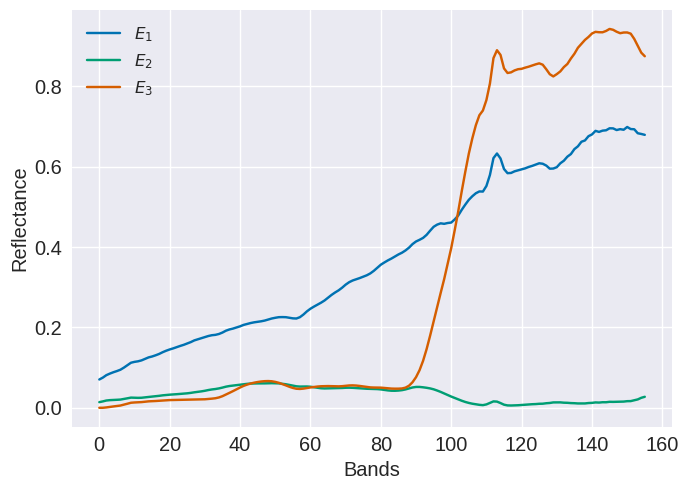

In [6]:
from utils import plot_endmembers
fig = plot_endmembers(endmember_init)
plt.show(fig)

In [7]:
# from pysptools import eea
# n_endmembers = dataset.n_endmembers + 25

# ee = eea.NFINDR()
# endmember = ee.extract(dataset.image().numpy(), n_endmembers)
# endmember_init = torch.from_numpy(endmember).float()
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# with plt.style.context(("seaborn-colorblind")):
#     plt.plot(endmember_init.T)
# plt.show()

In [8]:
# n_endmembers = dataset.n_endmembers + 0

# ee = eea.FIPPI()
# endmember = ee.extract(dataset.image().numpy(), n_endmembers-1)
# endmember_init = torch.from_numpy(endmember).float()
# endmember_init = endmember_init[1:]
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# with plt.style.context(("seaborn-colorblind")):
#     plt.plot(endmember_init.T)
# plt.show()



In [9]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:22<00:00,  2.18epoch/s, tls=0.0518]


In [10]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [11]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0236) tensor(0.5925) tensor(49.4311) tensor(0.1992)


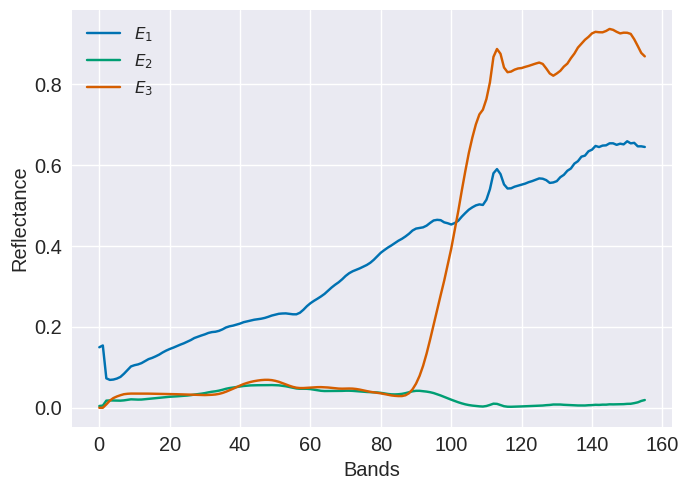

In [12]:
ebk = sigmoid(model.ebk).detach().cpu()
fig = plot_endmembers(ebk)
plt.show(fig)

In [13]:
# ordering the endmembers
endmembers = dataset.endmembers().detach().cpu()
from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

# reorder the endmembers
endmembers = endmembers[idx]

tensor([[0.0434, 0.4428, 0.7906],
        [0.9379, 1.3071, 0.1707],
        [0.4499, 0.0480, 1.1915]])
tensor([0, 2, 1])


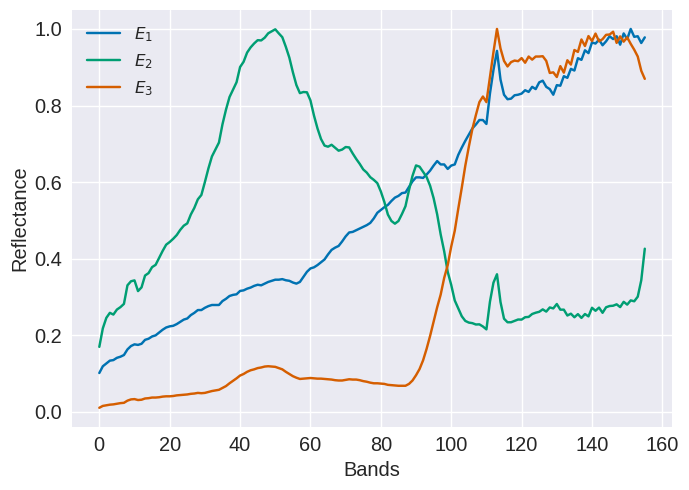

In [14]:
fig = plot_endmembers(endmembers)
plt.show(fig)

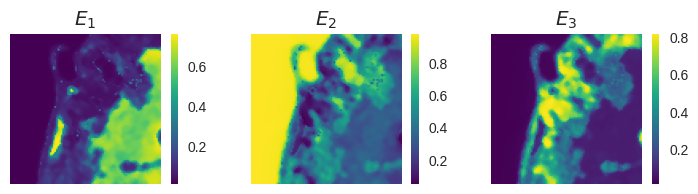

In [15]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

# with plt.style.context(("seaborn-colorblind")):
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [16]:
ebk = sigmoid(model.ebk).detach().cpu()
endmembers = dataset.endmembers()

from torch.nn.functional import mse_loss
def rmse(x: torch.Tensor, y: torch.Tensor):
    return torch.sqrt(mse_loss(x, y, reduction='none').mean(dim=1))

abundance = softmax(model.A.detach(), dim=1).cpu().reshape(dataset.n_row, dataset.n_col, n_endmembers)
abundance = abundance.permute(2,0,1)
abundance_gt = dataset.abundance()[:,:,idx].permute(2,0,1) # Reorder the ground truth
endmember_gt = dataset.endmembers()[idx, :]

rmse_result = rmse(abundance.flatten(1), abundance_gt.flatten(1))
print(rmse_result)

tensor([0.2481, 0.3911, 0.2438])


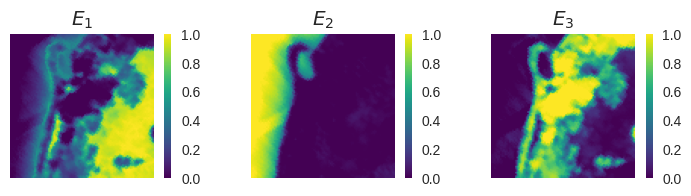

In [17]:
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(abundance_gt[i,:,:].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# Urban dataset

In [18]:
# from dataset import HSIDataset
# from torch import tensor
# import scipy.io as sio

# class Urban(HSIDataset):
#     def __init__(self, root_dir, transform=None):
#         super(Urban, self).__init__()

#         data = sio.loadmat(os.path.join(root_dir, 'Urban_R162.mat'))
#         # y = sio.loadmat(os.path.join(root_dir, 'groundTruth/end4_groundTruth.mat'))
#         y = sio.loadmat(os.path.join(root_dir, 'groundTruth_Urban_end5/end5_groundTruth.mat'))
#         # y = sio.loadmat(os.path.join(root_dir, 'groundTruth_Urban_end6/end6_groundTruth.mat'))

#         self.n_row, self.n_col = data['nRow'].item(), data['nCol'].item()

#         self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
#         self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
#         self.X = tensor(self.X, dtype=torch.float32)

#         self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
#         self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
#         self.n_endmembers = self.E.shape[0]
#         self.n_bands = self.E.shape[1] 

#         self.transform = transform

#     def __len__(self):
#         return self.n_row * self.n_col

#     def __getitem__(self, idx):
#         sample = self.X[idx]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

#     def endmembers(self):
#         return self.E

#     def abundance(self):
#         return self.A.reshape(self.n_row, self.n_col, -1)

#     def image(self):
#         return self.X.reshape(self.n_row, self.n_col, -1)

In [19]:
from dataset import Urban
dataset = Urban(root_dir=config.Urban_PATH)

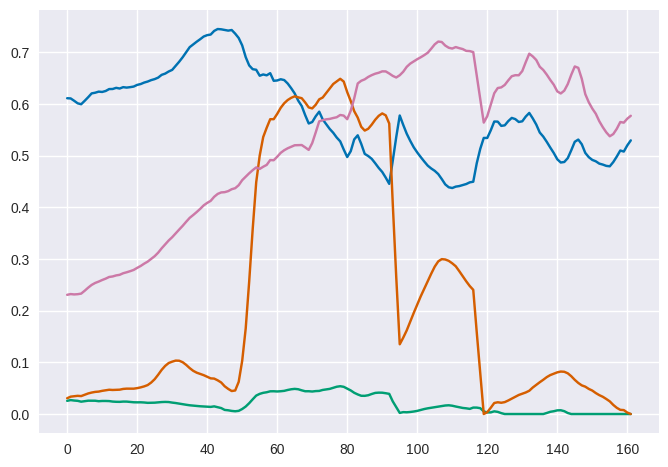

In [20]:
from HySpecLab.eea import VCA
n_endmembers = dataset.n_endmembers
endmembers = dataset.endmembers()

# from HySpecLab.metrics import sad
# import numpy as np
# for i in range(256):
#     vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=i)

#     E = vca.fit(dataset.X.numpy())
#     endmember_init = torch.from_numpy(vca.endmembers()).float()

#     sad_result = sad(endmember_init, endmembers)
#     idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
#     if np.unique(idx).shape[0] == n_endmembers:
#         print(i)
#         break

vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()

# forces that the max value of each ealemend is 1 - 1e-3, For testing!!
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .9
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))


with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember_init.T)
plt.show()

In [21]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:26<00:00,  1.88epoch/s, tls=0.0707]


In [22]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [23]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0371) tensor(0.6979) tensor(293.4286) tensor(0.2913)


In [24]:
volume_reg(endmember_init)

tensor(213.2097)

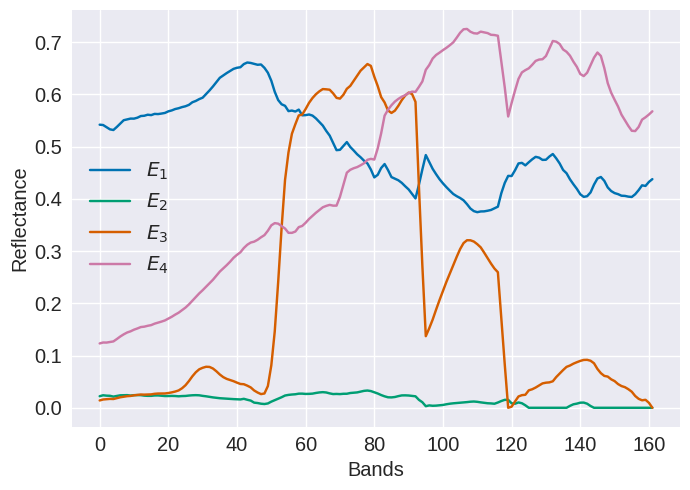

In [25]:
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
ebk = sigmoid(model.ebk).detach().cpu()
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(ebk.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    #legend background white
    plt.legend(fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

In [27]:
# ordering the endmembers
endmembers = dataset.endmembers().detach().cpu()
from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

idx[1] = 1
# idx[-1] = 1

# reorder the endmembers
endmembers = endmembers[idx]



tensor([[0.3526, 0.6156, 0.8481, 0.0708],
        [0.7664, 0.6805, 0.6231, 0.4780],
        [0.8546, 0.4252, 0.0943, 0.8280],
        [0.2221, 0.4244, 0.8445, 0.5748]])
tensor([3, 3, 2, 0])


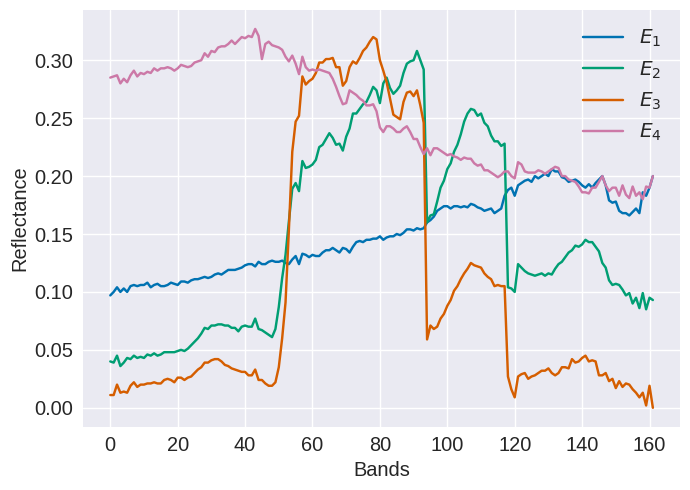

In [28]:
labels = list(map(lambda x: f'$E_{x}$', range(1, len(dataset.endmembers())+1)))
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(dataset.endmembers().T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    plt.legend(fontsize='x-large', facecolor='white')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    # plt.title('Ground Truth', fontsize='x-large')
    plt.tight_layout()
    plt.show()

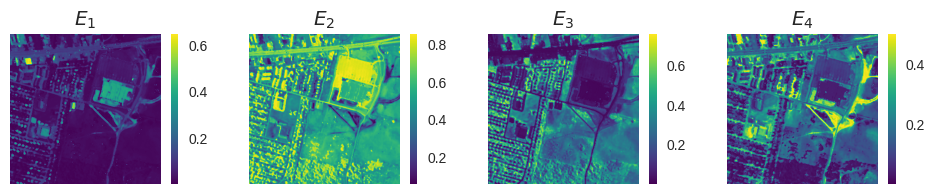

In [29]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

# with plt.style.context(("seaborn-colorblind")):
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [30]:
ebk = sigmoid(model.ebk).detach().cpu()
endmembers = dataset.endmembers()
print(endmembers.shape)

from torch.nn.functional import mse_loss
def rmse(x: torch.Tensor, y: torch.Tensor):
    return torch.sqrt(mse_loss(x, y, reduction='none').mean(dim=1))

abundance = softmax(model.A.detach(), dim=1).cpu().reshape(dataset.n_row, dataset.n_col, n_endmembers)
abundance = abundance.permute(2,0,1)
abundance_gt = dataset.abundance()[:,:,idx].permute(2,0,1) # Reorder the ground truth
print(abundance_gt.shape)
endmember_gt = dataset.endmembers()[idx, :]

rmse_result = rmse(abundance.flatten(1), abundance_gt.flatten(1))
print(rmse_result)

torch.Size([4, 162])
torch.Size([4, 307, 307])
tensor([0.1867, 0.4340, 0.2675, 0.3024])


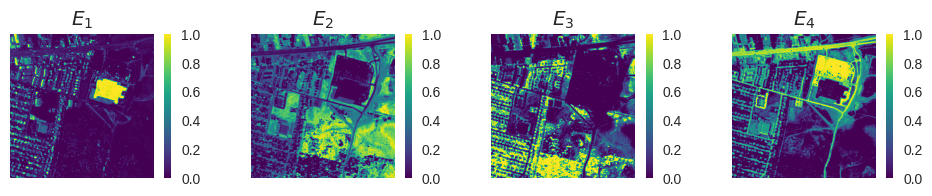

In [31]:
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(abundance_gt[i,:,:].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [33]:
dataset.endmembers().shape

torch.Size([4, 162])

# Cuprite

In [6]:
cuprite_save_path = os.path.join(config.IMG_PATH, 'Cuprite')

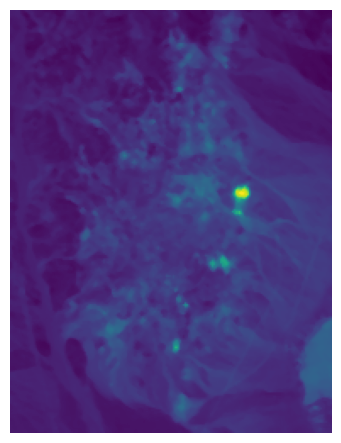

In [7]:
from dataset import Cuprite
dataset = Cuprite(config.Cuprite_PATH)

plt.imshow(dataset.image()[:,:,0], cmap='viridis')
plt.axis('off')
plt.show()

In [8]:
dataset.X.max()

tensor(0.9562)

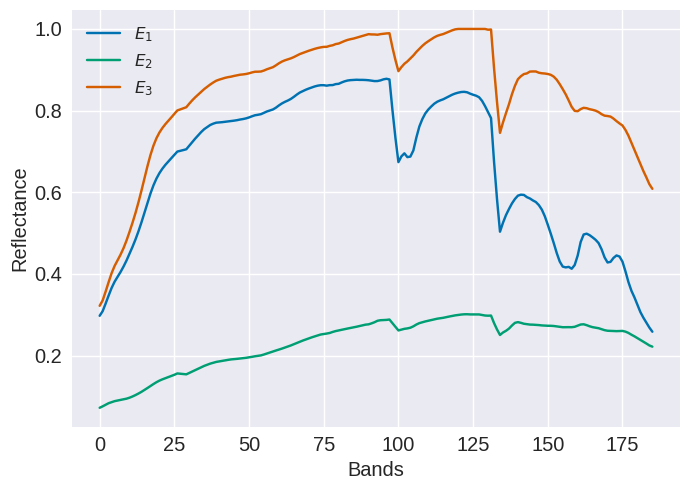

In [9]:
from HySpecLab.eea import VCA
# n_endmembers = dataset.n_endmembers
n_endmembers = 3


vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=1024)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()

# forces that the max value of each ealemend is 1 - 1e-3, For testing!!
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .9
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

from utils import plot_endmembers
fig = plot_endmembers(endmember_init)
plt.show(fig)
# with plt.style.context(("seaborn-colorblind")):
#     plt.plot(endmember_init.T)
# plt.show()

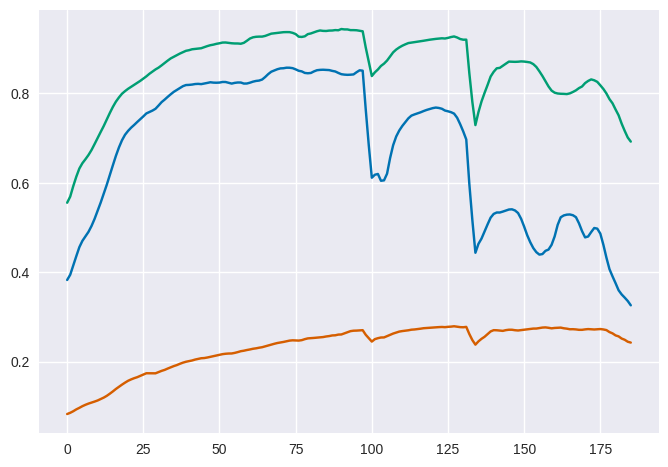

In [37]:
from pysptools import eea
# n_endmembers = dataset.n_endmembers
n_endmembers = 3

ee = eea.NFINDR()
endmember = ee.extract(dataset.image().numpy(), n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember_init.T)
plt.show()

In [38]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [39]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(49.2934), tensor(0.9375))

In [52]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
# train(model, n_endmembers, dataset, n_batchs=32, n_epochs=100, lr=1e-3)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=1e-3)

100%|██████████| 50/50 [00:22<00:00,  2.26epoch/s, tls=0.0599]


In [53]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [54]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0465) tensor(0.7594) tensor(0.6547) tensor(0.8487)


In [55]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(49.2934), tensor(0.9375))

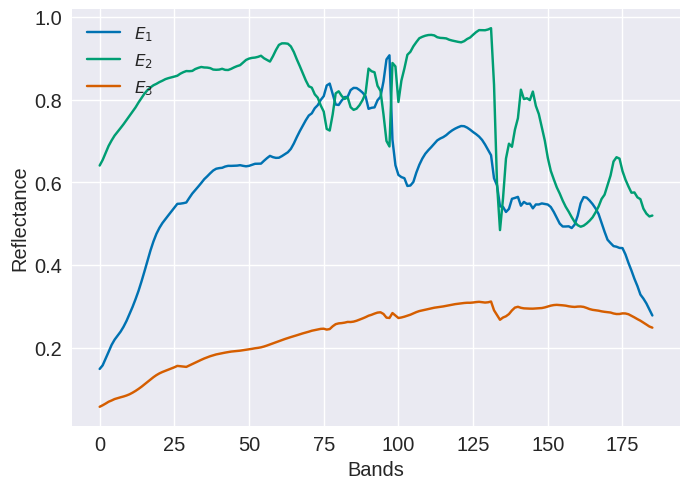

In [56]:
ebk = sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk)
plt.show(fig)

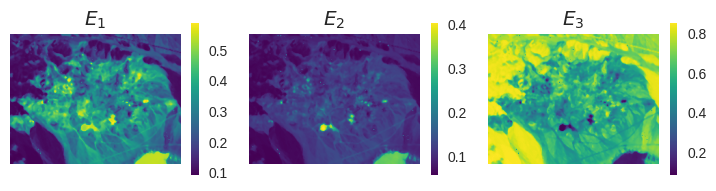

In [57]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

# with plt.style.context(("seaborn-colorblind")):
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [40]:
dataset[0].shape

torch.Size([186])

In [41]:
test = data['Y'].reshape(-1, data['nCol'].item(), data['nRow'].item())
test = test.transpose(1,2,0)
plt.imshow(test[:,:,100].T, cmap='viridis')
plt.show()
plt.axis('off')

NameError: name 'data' is not defined

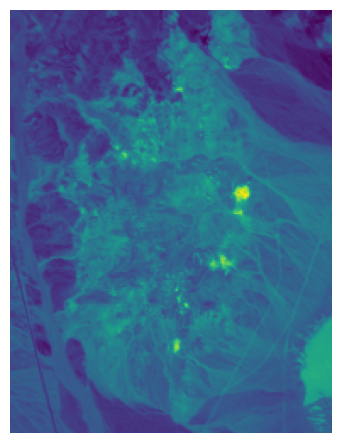

In [84]:
test = data['Y'].T.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')
plt.imshow(test[:,:,100], cmap='viridis')
plt.axis('off')
plt.show()

In [21]:
import scipy.io as sio
data = sio.loadmat(os.path.join('/home/abian/Data/Dataset/HSI/Cuprite/', 'CupriteS1_R188.mat'))

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SlectBands', 'nRow', 'nCol', 'nBand', 'Y'])

In [38]:
import numpy as np
X = data['Y'] / 2**16

In [44]:
data['Y'].T.reshape(data['nRow'], data['nCol'], -1)

TypeError: only integer scalar arrays can be converted to a scalar index

In [33]:
X.shape

(188, 47500)

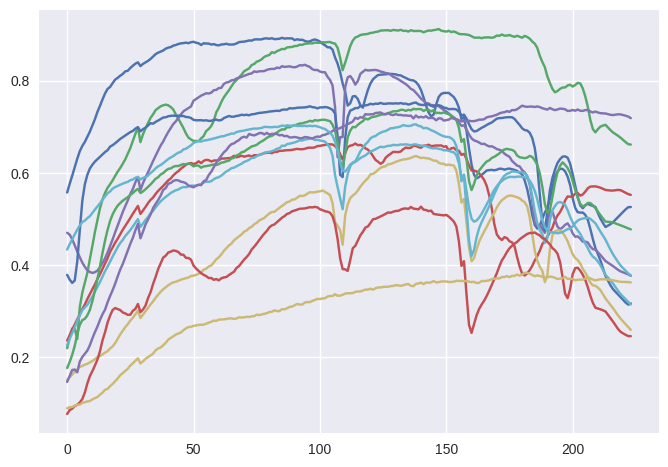

In [25]:
data = sio.loadmat(os.path.join('/home/abian/Data/Dataset/HSI/Cuprite', 'groundTruth_Cuprite_end12/groundTruth_Cuprite_nEnd12.mat'))
from matplotlib import pyplot as plt
plt.plot(data['M'])


In [20]:
data['M'].shape

(224, 12)